# PP5 - ML Brain Tumor Detector

## Notebook 3 - Modelling and Evaluation

### Objectives



### Inputs

| **input**      |          |       |
|-----------------|----------|-------|
| **train/**      | no_tumor | tumor |
| **test/**       | no_tumor | tumor |
| **validation/** | no_tumor | tumor |


### Outputs




### Additional Comments

* Dataset: [Kaggle](https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri?select=Training)
* License: [MIT](https://www.mit.edu/~amini/LICENSE.md)

---

## Set Data Directory

### Import Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
sns.set_style("white")
from matplotlib.image import imread

### Set Working Directory

In [2]:
cwd= os.getcwd()

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/ml-brain-tumor-detection/jupyter_notebooks'

In [4]:
os.chdir('/workspace/ml-brain-tumor-detection')
print("You set a new current directory")

You set a new current directory


In [5]:
working_dir = os.getcwd()
working_dir

'/workspace/ml-brain-tumor-detection'

### Set Input Directory

In [6]:
data_dir= 'input/brain-mri-scans'
train_path = data_dir + '/train'
val_path = data_dir + '/validation'
test_path = data_dir + '/test'
print(f"Train Set Path: {train_path}")
print(f"Validation Set Path: {val_path}")
print(f"Test Set Path: {test_path}")


Train Set Path: input/brain-mri-scans/train
Validation Set Path: input/brain-mri-scans/validation
Test Set Path: input/brain-mri-scans/test


### Set Output Directory

In [7]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(working_dir) and version in os.listdir(working_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

print(file_path)

Old version is already available create a new version.
outputs/v1


### Set Label Names

In [8]:
labels = os.listdir(train_path)
print('Label for the images are', labels)

Label for the images are ['tumor', 'no_tumor']


### Set Image Shape

In [9]:
image_shape = joblib.load(filename=f"outputs/{version}/avg_image_shape_train.pkl")
image_shape

(469, 466, 3)

---

## Number of images in train, test and validation data

* test - tumor: 554 images
* test - no_tumor: 100 images
* train - tumor: 1934 images
* train - no_tumor: 350 images
* validation - tumor: 276 images
* validation - no_tumor: 50 images




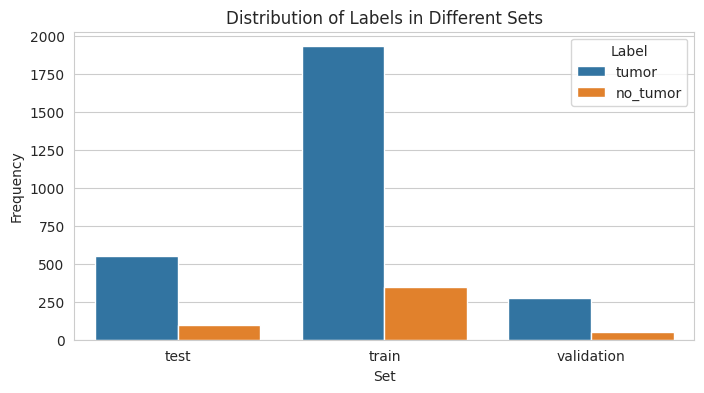

Total data across all labels: 3264
Total data in no_tumor: 500
Total data in tumor: 2764



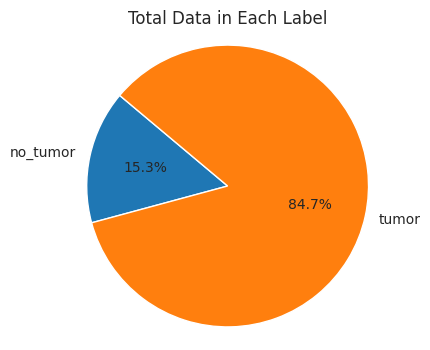

In [10]:
data = []
for folder in ['test', 'train', 'validation']:
    folder_path = os.path.join(data_dir, folder)
    for label in labels:
        label_path = os.path.join(folder_path, label)
        frequency = len(os.listdir(label_path))
        data.append({'Set': folder, 'Label': label, 'Frequency': frequency})
        print(f"* {folder} - {label}: {frequency} images")

print("\n")

# DataFrame
df_freq = pd.DataFrame(data)

# Calculate total data across all labels
total_data_all_labels = df_freq['Frequency'].sum()

# Calculate total data in each label
total_data_per_label = df_freq.groupby('Label')['Frequency'].sum()

# Generate string output
string_output = f"Total data across all labels: {total_data_all_labels}\n"
for label, total in total_data_per_label.items():
    string_output += f"Total data in {label}: {total}\n"


# Plotting the bar plot
sns.set_style("whitegrid")
plt.figure(figsize=(8, 4))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.title('Distribution of Labels in Different Sets')
plt.xlabel('Set')
plt.ylabel('Frequency')
plt.savefig(f'{file_path}/labels_distribution_bar.png', bbox_inches='tight', dpi=150)
plt.show()

# Plotting total data string
print(string_output)

# Plotting the pie chart
plt.figure(figsize=(4, 4))
plt.pie(total_data_per_label, labels=total_data_per_label.index, autopct='%1.1f%%', startangle=140)
plt.title('Total Data in Each Label')
plt.axis('equal')
plt.savefig(f'{file_path}/labels_pie_chart.png', bbox_inches='tight', dpi=150)
plt.show()

### Conclusion of Dataset distribution

As we can see, the data in each label for "no_tumor" and "tumor" is highly imbalanced. This could pose challanges for data analysis such as:
+ **Bias in Model Training:**  
Class imbalances can lead to bias in model training, where the model may become more biased towards the majority class. In this case the "tumor" images.

+ **Poor Generalization:**  
    Models trained on imbalanced datasets may have difficulty generalizing well to unseen data, especially for the minority class.

+ **Evaluation Metrics:**
Traditional evaluation metrics such as accuracy may not provide an accurate representation of the model's performance, especially in imbalanced datasets. For instance, a model that always predicts the majority class (tumor) would achieve high accuracy but provide little to no value in detecting the minority class (no_tumor).

+ **Decision Boundaries:**  
Imbalance in the dataset can influence the decision boundaries learned by the model, potentially leading to misclassification of the minority class instances.

To combat these issues, it is essential to address the class imbalance through techniques such as:
+ **Data Resampling:**  
Oversampling the minority class or undersampling the majority class to balance the dataset.

+ **Data Augmentation:**  
Introduce variations to existing data samples, such as rotation, scaling, flipping, cropping, or adding noise. This can help in creating additional training examples, especially for the minority class.

+ **Evaluation Metrics:**  
Focusing on metrics like precision, recall, F1-score, or area under the ROC curve (AUC-ROC) that provide insights into the model's performance across different classes.

---

## Image Augmentation

### Import ImageDataGenerator from tensorflow 

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-04-13 11:07:05.754824: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


**Augmentation Pipeline**

In [12]:
augmentation_data = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.15,
    rotation_range=20,
    shear_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.5, 1.5],
    fill_mode='nearest',
    rescale=1.0/255.0,
)

**Batch Size**

In [13]:
batch_size = 20

**Augmentation Train image Set**

In [14]:
train_set = augmentation_data.flow_from_directory(
    train_path,
    target_size=image_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
    )

train_set.class_indices

Found 2284 images belonging to 2 classes.


{'no_tumor': 0, 'tumor': 1}

**Augmentation Validation image Set**

In [15]:
validation_set = augmentation_data.flow_from_directory(
    val_path,
    target_size=image_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
    )

validation_set.class_indices

Found 326 images belonging to 2 classes.


{'no_tumor': 0, 'tumor': 1}

**Augmentation Test image Set**

In [16]:
test_set = augmentation_data.flow_from_directory(
    test_path,
    target_size=image_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
    )

test_set.class_indices

Found 654 images belonging to 2 classes.


{'no_tumor': 0, 'tumor': 1}

**Plot augmented Train image set**

In [17]:
import matplotlib.pyplot as plt

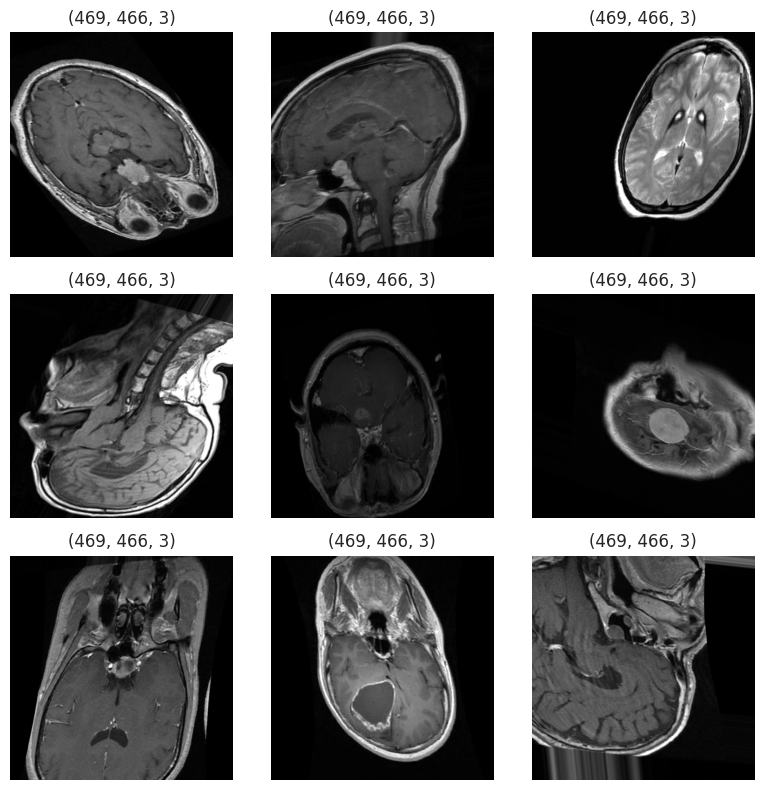

In [18]:
fig, axes = plt.subplots(3, 3, figsize=(8, 8))

for i in range(9):
    img, _ = next(train_set)
    
    axes[i // 3, i % 3].imshow(img[0])
    axes[i // 3, i % 3].set_title(f'{img[0].shape}')
    
    axes[i // 3, i % 3].axis('off')

plt.tight_layout()
plt.show()

**Plot augmented Validation image set**

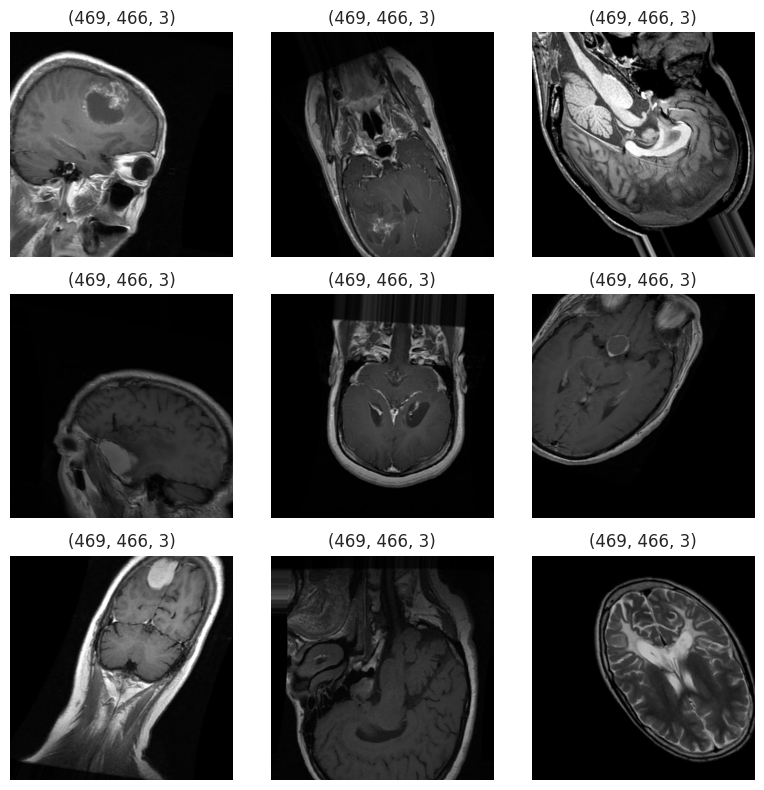

In [19]:
fig, axes = plt.subplots(3, 3, figsize=(8, 8))

for i in range(9):
    img, _ = next(validation_set)
    
    axes[i // 3, i % 3].imshow(img[0])
    axes[i // 3, i % 3].set_title(f'{img[0].shape}')
    
    axes[i // 3, i % 3].axis('off')

plt.tight_layout()
plt.show()

**Plot augmented Test image set**

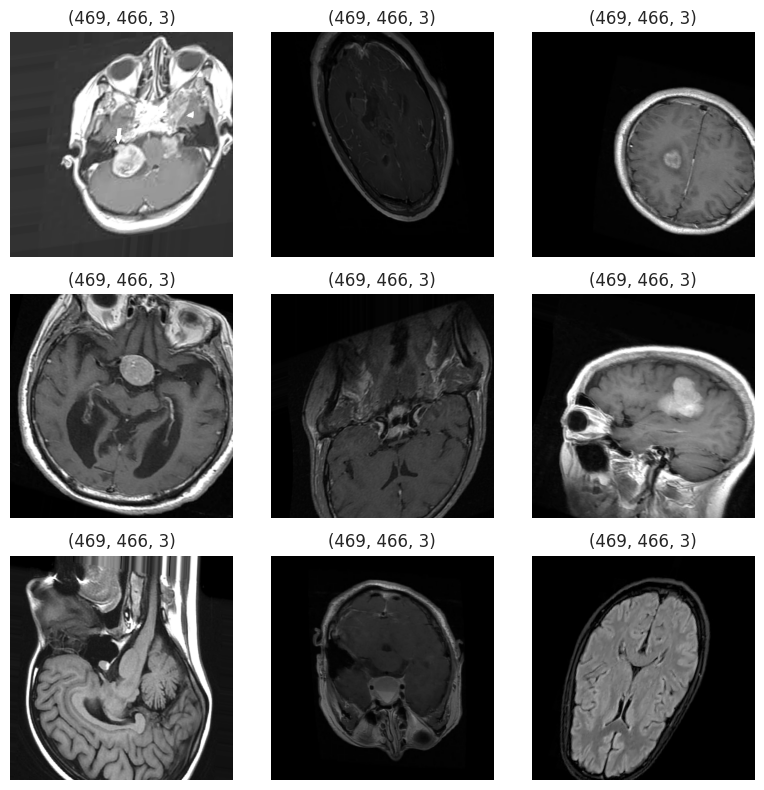

In [20]:
fig, axes = plt.subplots(3, 3, figsize=(8, 8))

for i in range(9):
    img, _ = next(test_set)
    
    axes[i // 3, i % 3].imshow(img[0])
    axes[i // 3, i % 3].set_title(f'{img[0].shape}')
    
    axes[i // 3, i % 3].axis('off')

plt.tight_layout()
plt.show()

**Save class_indicies**

In [21]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

## Building the Model

**Calculate class weights**

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_set.classes),
    y=train_set.classes
    )

class_weights_dict = dict(enumerate(class_weights))

**Import Model Packages**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPooling2D, Conv2D, Flatten, Dense, Dropout

**Building the Model**

In [ ]:
def build_model(hyper):
    """
Description:
    Builds a convolutional neural network (CNN) model with hyperparameters for hyperparameter tuning

Parameters:
    hyper - HyperParameters:   A HyperParameters object containing the hyperparameters to tune the model
    image_shape - tuple:    The shape of input images (height, width, channels)

Returns:
    model - Sequential:     A TensorFlow Keras Sequential model configured with the specified hyperparameters
"""
    
    model = Sequential()

    model.add(Conv2D(filters=8, kernel_size=(1, 1), input_shape=image_shape,
                     activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=16, kernel_size=(2, 2), input_shape=image_shape,
                     activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=image_shape,
                     activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    hyper_units = hyper.Int('units', min_value=32, max_value=128, step=16)
    model.add(Dense(units=hyper_units, activation='relu'))

    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    hyper_learning_rate = hyper.Choice('learning_rate', values=[1e-3, 5e-4, 1e-4])
    opt = keras.optimizers.Adam(learning_rate=hyper_learning_rate)

    model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

    return model

**Import Hyperparameter Tuning Packages**

In [ ]:
from tensorflow import keras
from keras_tuner import Hyperband

**Defining Hyperband Tuner Configuration**

In [ ]:
tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=5,
    factor=3,
    directory='my_dir',
    project_name='mri_tumor_tuning'
)

**Setting Up Early Stopping Callback**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

**Training the Model with Hyperparameter Tuning**

In [ ]:
# Start the model training
tuner.search(train_set, validation_data=validation_set, callbacks=[early_stop])

# Get the best hyperparameters
best_hypers = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hypers)

# Train the model with the best hyperparameters
history = best_model.fit(
    train_set, 
    epochs=10,
    validation_data=validation_set,
    class_weight=class_weights_dict,
    callbacks=[early_stop]
)


"Summary of Model Built with Best Hyperparameters"

In [ ]:
model = tuner.hypermodel.build(best_hypers)

model.summary()


**Visualizing Model Training History**

In [ ]:
losses = pd.DataFrame(history.history)

# Plot training losses
sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png', bbox_inches='tight', dpi=150)
plt.show()

# Plot training accuracy
print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png', bbox_inches='tight', dpi=150)
plt.show()